In [7]:
!pip install pandas numpy torch transformers datasets scikit-learn matplotlib seaborn
!pip install accelerate

📥 Loading filtered Excel dataset...
✅ Loaded dataset with 109810 rows

🔀 Splitting dataset into 80% train, 20% test...
✅ Train size: 87848, Test size: 21962

⚖️ Computing class weights...
✅ Class weights: [1.8439966440200806, 0.6860123872756958]

🔤 Tokenizing text...
✅ Tokenization complete.

🧠 Loading BERT model...


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/common/home/projectgrps/IS424/IS424G4/jupyterlab-venv-pytorch-240/lib/python3.11/site-packages/transformers/training_args.py:1594: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(



🚦 Training started...


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.372000,0.386374,0.855705,0.901231,0.899241,0.903230
2,0.315200,0.369706,0.849149,0.893332,0.921672,0.866683
3,0.150100,0.567763,0.867635,0.909318,0.908100,0.910539


✅ Training complete.

📈 Evaluating on test set...



📊 Classification Report:
              precision    recall  f1-score   support

     REFUTES   0.691172  0.802015  0.742480      5955
    SUPPORTS   0.921672  0.866683  0.893332     16007

    accuracy                       0.849149     21962
   macro avg   0.806422  0.834349  0.817906     21962
weighted avg   0.859172  0.849149  0.852428     21962


🧮 Confusion Matrix:
[[ 4776  1179]
 [ 2134 13873]]


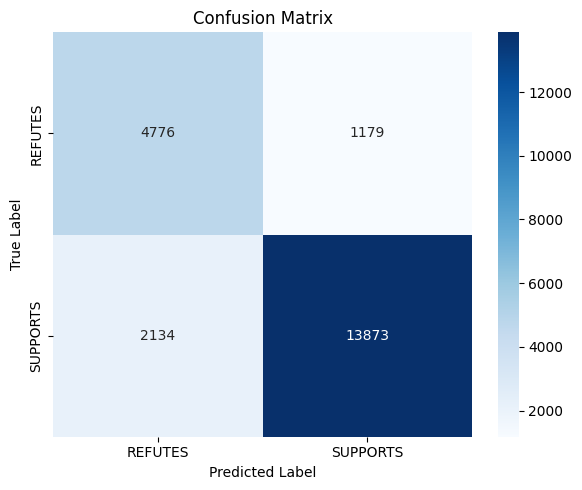


📐 ROC AUC Score: 0.918935


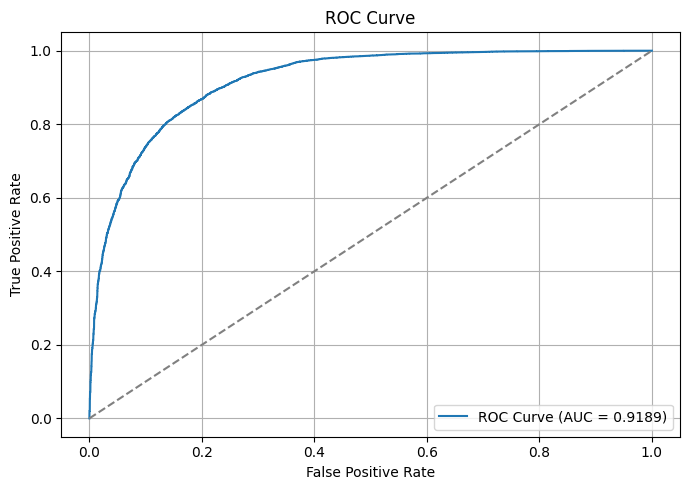

In [ ]:
# 📦 Imports
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import re
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, classification_report, confusion_matrix, roc_auc_score, roc_curve
from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments, EarlyStoppingCallback
from datasets import Dataset
import matplotlib.pyplot as plt
import seaborn as sns
import torch.nn.functional as F


# ------------------------------
# ✅ Load filtered Excel dataset
# ------------------------------
print("📥 Loading filtered Excel dataset...")
df = pd.read_excel("../data/filtered_fever_data.xlsx")
df = df[df["label"].isin(["SUPPORTS", "REFUTES"])]
df["label"] = df["label"].map({"SUPPORTS": 1, "REFUTES": 0})
print(f"✅ Loaded dataset with {len(df)} rows")

# ------------------------------
# ✅ Train-Test Split (80/20)
# ------------------------------
print("\n🔀 Splitting dataset into 80% train, 20% test...")
train_df, test_df = train_test_split(df, test_size=0.2, stratify=df["label"], random_state=42)
print(f"✅ Train size: {len(train_df)}, Test size: {len(test_df)}")

# ------------------------------
# ✅ Compute Class Weights
# ------------------------------
print("\n⚖️ Computing class weights...")
class_weights = compute_class_weight(class_weight="balanced", classes=np.array([0, 1]), y=train_df["label"].values)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
class_weights = torch.tensor(class_weights, dtype=torch.float).to(device)
print(f"✅ Class weights: {class_weights.tolist()}")

# ------------------------------
# ✅ Tokenization
# ------------------------------
print("\n🔤 Tokenizing text...")
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
train_encodings = tokenizer(train_df["claim"].tolist(), truncation=True, padding=True, max_length=128)
test_encodings = tokenizer(test_df["claim"].tolist(), truncation=True, padding=True, max_length=128)
print("✅ Tokenization complete.")

# ------------------------------
# ✅ Convert to Hugging Face Dataset
# ------------------------------
train_dataset = Dataset.from_dict({
    "input_ids": train_encodings["input_ids"],
    "attention_mask": train_encodings["attention_mask"],
    "labels": train_df["label"].tolist()
})
test_dataset = Dataset.from_dict({
    "input_ids": test_encodings["input_ids"],
    "attention_mask": test_encodings["attention_mask"],
    "labels": test_df["label"].tolist()
})

# ------------------------------
# ✅ Load BERT Model
# ------------------------------
print("\n🧠 Loading BERT model...")
model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=2)
model.to(device)

# ------------------------------
# ✅ Custom Trainer with Weighted Loss
# ------------------------------
class WeightedLossTrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False, **kwargs):
        labels = inputs.pop("labels").to(device)
        outputs = model(**inputs)
        logits = outputs.logits
        loss_fn = nn.CrossEntropyLoss(weight=class_weights)
        loss = loss_fn(logits, labels)
        return (loss, outputs) if return_outputs else loss

# ------------------------------
# ✅ Training Arguments
# ------------------------------
training_args = TrainingArguments(
    output_dir="./results",
    evaluation_strategy="epoch",
    save_strategy="epoch",
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=4,
    weight_decay=0.01,
    learning_rate=3e-5,
    logging_steps=50,
    save_total_limit=1,
    load_best_model_at_end=True,
    gradient_accumulation_steps=2,
    metric_for_best_model="eval_loss",
    greater_is_better=False
)

# ------------------------------
# ✅ Trainer Initialization
# ------------------------------
trainer = WeightedLossTrainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    compute_metrics=lambda pred: {
        "accuracy": accuracy_score(pred.label_ids, pred.predictions.argmax(-1)),
        "f1": precision_recall_fscore_support(pred.label_ids, pred.predictions.argmax(-1), average='binary')[2],
        "precision": precision_recall_fscore_support(pred.label_ids, pred.predictions.argmax(-1), average='binary')[0],
        "recall": precision_recall_fscore_support(pred.label_ids, pred.predictions.argmax(-1), average='binary')[1],
    },
    callbacks=[EarlyStoppingCallback(early_stopping_patience=2)]
)

# ------------------------------
# ✅ Train
# ------------------------------
print("\n🚦 Training started...")
trainer.train()
print("✅ Training complete.")

# ------------------------------
# ✅ Evaluation
# ------------------------------
print("\n📈 Evaluating on test set...")
predictions = trainer.predict(test_dataset)
y_true = predictions.label_ids
y_pred = predictions.predictions.argmax(-1)

# Report
print("\n📊 Classification Report:")
print(classification_report(y_true, y_pred, target_names=["REFUTES", "SUPPORTS"], digits=6))

print("\n🧮 Confusion Matrix:")
print(confusion_matrix(y_true, y_pred))

# Plot Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=["REFUTES", "SUPPORTS"], yticklabels=["REFUTES", "SUPPORTS"])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.tight_layout()
plt.show()

# ------------------------------
# ✅ ROC AUC and ROC Curve
# ------------------------------
# Get predicted probabilities for class 1 (SUPPORTS)
probs = torch.softmax(torch.tensor(predictions.predictions), dim=1).numpy()
y_probs = probs[:, 1]

# Calculate ROC AUC score
roc_auc = roc_auc_score(y_true, y_probs)

# Print ROC AUC score
print(f"\n📐 ROC AUC Score: {roc_auc:.6f}")

# Plot ROC Curve
fpr, tpr, thresholds = roc_curve(y_true, y_probs)

plt.figure(figsize=(7, 5))
plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {roc_auc:.4f})")
plt.plot([0, 1], [0, 1], linestyle="--", color="gray")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
#with focalloss

📥 Loading filtered Excel dataset...
✅ Loaded dataset with 109810 rows

🔀 Splitting into train/test sets...
✅ Train size: 87848, Test size: 21962

🔤 Tokenizing...
✅ Tokenization complete.

🧠 Loading BERT model...


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



🧩 Defining custom Trainer with Focal Loss...

🚦 Starting training...


/common/home/projectgrps/IS424/IS424G4/jupyterlab-venv-pytorch-240/lib/python3.11/site-packages/transformers/training_args.py:1594: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Epoch,Training Loss,Validation Loss
1,0.095700,0.093533
2,0.078900,0.095646
3,0.048300,0.140941


✅ Training complete.

📈 Final Evaluation...



📊 Classification Report:
              precision    recall  f1-score   support

     REFUTES   0.769121  0.724433  0.746109      5955
    SUPPORTS   0.899651  0.919098  0.909271     16007

    accuracy                       0.866315     21962
   macro avg   0.834386  0.821766  0.827690     21962
weighted avg   0.864258  0.866315  0.865029     21962


🧮 Confusion Matrix:
[[ 4314  1641]
 [ 1295 14712]]

📐 ROC AUC Score: 0.915406


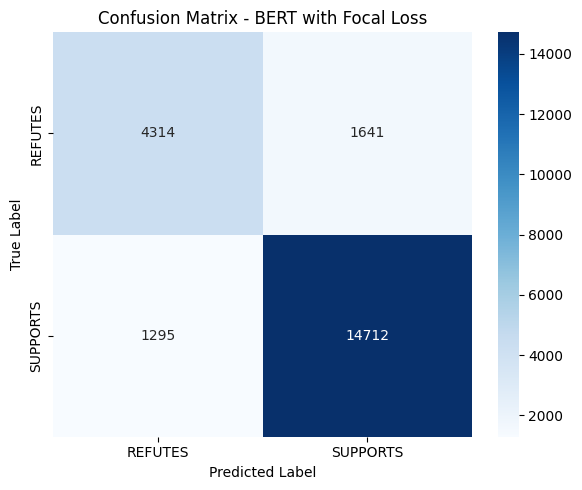

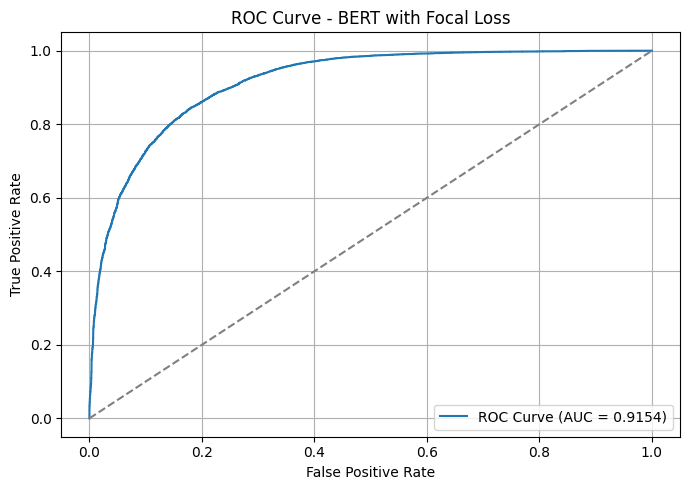

In [ ]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import re
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, classification_report, confusion_matrix, roc_auc_score, roc_curve
from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments, EarlyStoppingCallback
from datasets import Dataset
import matplotlib.pyplot as plt
import seaborn as sns
import torch.nn.functional as F

# ------------------------------
# ✅ Load Dataset
# ------------------------------
print("📥 Loading filtered Excel dataset...")
df = pd.read_excel("../data/filtered_fever_data.xlsx")
df = df[df["label"].isin(["SUPPORTS", "REFUTES"])]
df["label"] = df["label"].map({"SUPPORTS": 1, "REFUTES": 0})
print(f"✅ Loaded dataset with {len(df)} rows")

# ------------------------------
# ✅ Train-Test Split
# ------------------------------
print("\n🔀 Splitting into train/test sets...")
train_df, test_df = train_test_split(df, test_size=0.2, stratify=df["label"], random_state=42)
print(f"✅ Train size: {len(train_df)}, Test size: {len(test_df)}")

# ------------------------------
# ✅ Tokenization
# ------------------------------
print("\n🔤 Tokenizing...")
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
train_encodings = tokenizer(train_df["claim"].tolist(), truncation=True, padding=True, max_length=128)
test_encodings = tokenizer(test_df["claim"].tolist(), truncation=True, padding=True, max_length=128)
print("✅ Tokenization complete.")

# ------------------------------
# ✅ Hugging Face Dataset format
# ------------------------------
train_dataset = Dataset.from_dict({
    "input_ids": train_encodings["input_ids"],
    "attention_mask": train_encodings["attention_mask"],
    "labels": train_df["label"].tolist()
})
test_dataset = Dataset.from_dict({
    "input_ids": test_encodings["input_ids"],
    "attention_mask": test_encodings["attention_mask"],
    "labels": test_df["label"].tolist()
})

# ------------------------------
# ✅ Load BERT Model
# ------------------------------
print("\n🧠 Loading BERT model...")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=2)
model.to(device)

# ------------------------------
# ✅ Focal Loss Implementation
# ------------------------------
class FocalLoss(nn.Module):
    def __init__(self, alpha=None, gamma=2.0, reduction='mean'):
        super(FocalLoss, self).__init__()
        self.gamma = gamma
        self.reduction = reduction
        self.alpha = alpha

    def forward(self, logits, labels):
        ce_loss = nn.CrossEntropyLoss(reduction='none')(logits, labels)
        pt = torch.exp(-ce_loss)
        focal_loss = (1 - pt) ** self.gamma * ce_loss

        if self.alpha is not None:
            at = self.alpha.gather(0, labels)
            focal_loss = focal_loss * at

        if self.reduction == 'mean':
            return focal_loss.mean()
        elif self.reduction == 'sum':
            return focal_loss.sum()
        else:
            return focal_loss

# ------------------------------
# ✅ Custom Trainer using Focal Loss
# ------------------------------
print("\n🧩 Defining custom Trainer with Focal Loss...")
class FocalLossTrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False, **kwargs):
        labels = inputs.pop("labels").to(device)
        outputs = model(**inputs)
        logits = outputs.logits

        # Optional: Alpha can be set per class
        alpha = torch.tensor([1.5, 0.8]).to(device)  # [REFUTES, SUPPORTS]
        loss_fn = FocalLoss(alpha=alpha, gamma=2)
        loss = loss_fn(logits, labels)

        return (loss, outputs) if return_outputs else loss

# ------------------------------
# ✅ Training Arguments
# ------------------------------
training_args = TrainingArguments(
    output_dir="./results_focal",
    evaluation_strategy="epoch",
    save_strategy="epoch",
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=4,
    weight_decay=0.01,
    learning_rate=3e-5,
    logging_steps=50,
    save_total_limit=1,
    load_best_model_at_end=True,
    lr_scheduler_type="linear",
    gradient_accumulation_steps=2,
    metric_for_best_model="eval_loss",
    greater_is_better=False
)

# ------------------------------
# ✅ Trainer Initialization
# ------------------------------
trainer = FocalLossTrainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=2)]
)

# ------------------------------
# ✅ Training
# ------------------------------
print("\n🚦 Starting training...")
trainer.train()
print("✅ Training complete.")

# ------------------------------
# ✅ Final Evaluation
# ------------------------------
print("\n📈 Final Evaluation...")
predictions = trainer.predict(test_dataset)
y_true = predictions.label_ids
y_pred = predictions.predictions.argmax(-1)

# 📊 Classification Report
print("\n📊 Classification Report:")
print(classification_report(y_true, y_pred, target_names=["REFUTES", "SUPPORTS"], digits=6))

# 🧮 Confusion Matrix
print("\n🧮 Confusion Matrix:")
cm = confusion_matrix(y_true, y_pred)
print(cm)

# 🔮 Get predicted probabilities for class 1 (SUPPORTS)
probs = torch.softmax(torch.tensor(predictions.predictions), dim=1).numpy()
y_probs = probs[:, 1]

# 📐 ROC AUC Score
from sklearn.metrics import roc_auc_score, roc_curve

roc_auc = roc_auc_score(y_true, y_probs)
print(f"\n📐 ROC AUC Score: {roc_auc:.6f}")

# 📉 Plot Confusion Matrix
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=["REFUTES", "SUPPORTS"], yticklabels=["REFUTES", "SUPPORTS"])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix - BERT with Focal Loss")
plt.tight_layout()
plt.show()

# 📈 Plot ROC Curve
fpr, tpr, thresholds = roc_curve(y_true, y_probs)

plt.figure(figsize=(7, 5))
plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {roc_auc:.4f})")
plt.plot([0, 1], [0, 1], linestyle="--", color="gray")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - BERT with Focal Loss")
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()
plt.show()